# Notebook to develop HMM model to investigate optimal angle selection

## Defining the targets we will be using in our multiaspect classification model

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.gridspec as gridspec

from scipy.special import spherical_jn, spherical_yn

import ipywidgets as widgets
from IPython.display import display

## Below is the analytical DWBA solution for a prolate spheroid geometry

In [2]:
def dwba_prolate_spheroid(L, a, g, h, ka, phi):
    """
    DWBA solution for a fluid prolate spheroid.
    Lee, W.-J., Lavery, A. C., and Stanton, T. K. (2012). 
    “Orientation dependence of broadband acoustic backscattering from live squid,” 
    The Journal of the Acoustical Society of America, 131, 4461–4475. doi:10.1121/1.3701876
    
    Parameters
    ----------
    L : float
        Length of spheroid (long axis) [m]
    a : float
        Radius of spheroid (short axis) [m]
    g : float
        Density contrast (rho2/rho1)
    h : float
        Sound speed contrast (c2/c1)
    ka : array_like
        Dimensionless ka (wavenumber * radius)
    phi : float or array_like
        Incident angle [radians]

    Returns
    -------
    fbs : array_like
        Complex backscattering amplitude
    """
    # Convert inputs to arrays and ensure proper broadcasting
    ka = np.atleast_1d(ka)
    phi = np.atleast_1d(phi)

    # Calculate contrast term
    contrast = 1/(g * h**2) + 1/g - 2
    
    # Convert incident angle to beta
    beta = phi[..., np.newaxis] + np.pi / 2  # Add dimension for broadcasting with ka
    # beta = phi + np.pi/2
    
    # Calculate aspect ratio term (L/2a)
    aspect_ratio = L / (2 * a)

    # Calculate argument for Bessel function
    ellip_term = np.sqrt(np.sin(beta)**2 + (aspect_ratio**2) * np.cos(beta)**2)
    bessel_arg = 2 * ka / h * ellip_term
    
    # Calculate spherical Bessel function
    j1 = spherical_jn(1, bessel_arg)
    
    # Calculate final backscattering amplitude
    fbs = (ka**2) * L * contrast/2 * j1/bessel_arg

    return fbs.squeeze()

## Defining the measurement and target constants

In [3]:
a = 0.15 # semi-minor axis (equatorial radius)
g = 1.043 # density contrast
h = 1.053 # sound speed contrast
c = 1500 # speed of sound in water

freq_lowerbound = 100 # frequency response lower bound
freq_upperbound = 30e3 # frequency response upper bound
freq = np.arange(freq_lowerbound, freq_upperbound, 10)
k = 2*np.pi*freq / c # acoustic wavenumber (phase shift per meter)
ka = k*a

measurement_angle_step = 0.5
angle_all = np.arange(0, 360, measurement_angle_step)

## Below is code borrowed from the [BOAT fundamentals repository](https://boat-fundamentals.readthedocs.io/en/latest/acoustics/TS_03_discrete.html#orientation-dependency)

It has been modified to include an aspect ratio parameter so we can see the 2 targets we need using the slider: a sphere (AR = 1) and spheroid (AR > 1)

In [4]:
def plot_dwba_for_prolate_spheroid(angle, aspect_ratio):
    L = aspect_ratio*2*a

    # TS across all angles
    phi_all = np.deg2rad(angle_all)
    fbs_full = dwba_prolate_spheroid(L, a, g, h, ka, phi_all)
    TS_all = 20*np.log10(np.abs(fbs_full))

    phi = np.deg2rad(angle)
    fbs = dwba_prolate_spheroid(L, a, g, h, ka, phi)
    TS = 20*np.log10(np.abs(fbs))

    # Define ellipse parameters
    width = 2*a  # width
    height = L  # height
    ellipse_angle = 90-angle  # rotation angle [deg]

    # Create the ellipse patch
    ellipse = patches.Ellipse(
        (0.5, 0.5), width, height, angle=ellipse_angle, 
        facecolor='lightblue', edgecolor='blue')

    fig = plt.figure(figsize=(7,6))
    gs = gridspec.GridSpec(2, 2, width_ratios=[2, 1])
    fig.subplots_adjust(hspace=0.1)

    # All angles
    ax0 = fig.add_subplot(gs[0,0])
    ax0.imshow(TS_all, aspect="auto", vmax=-25, vmin=-80,
                extent=(0, freq_upperbound//1e3, 0, 360))
    ax0.set_yticks(np.arange(0, 361, 60))
    ax0.set_ylabel("Incident angle (°)", fontsize=12)
    ax0.set_xlim(freq_lowerbound, freq_upperbound)
    ax0.axhline(angle, color="magenta")

    # One angle slice
    ax1 = fig.add_subplot(gs[1,0], sharex=ax0)
    ax1.plot(freq/1e3, TS, lw=0.75)
    ax1.set_xlim(freq_lowerbound/1e3, freq_upperbound/1e3)
    ax1.set_ylim(-90, -20)
    ax1.set_xlabel("Frequency (kHz)", fontsize=12)
    ax1.set_ylabel("TS (dB)", fontsize=12)

    # Ellipse (cross section of prolate spheroid)
    ax_ellip = fig.add_subplot(gs[1,1])
    ax_ellip.add_patch(ellipse)
    ax_ellip.annotate("Incident sound", xytext=(0.5, 1.2), xy=(0.5, 0.95),
        arrowprops=dict(arrowstyle="->,head_length=0.5,head_width=0.3",
                        linewidth=2),
        fontsize=12,
        ha="center")
    ax_ellip.set_aspect('equal', adjustable='box')
    ax_ellip.axis('off')
    ax_ellip.set_xlim(0, 1)
    ax_ellip.set_ylim(0, 1.2)

    ax0.set_title("TS of a fluid prolate spheroid")
    plt.tight_layout()
    plt.show()

    return TS_all

## Below I have attached two visualizations but both are using the same function

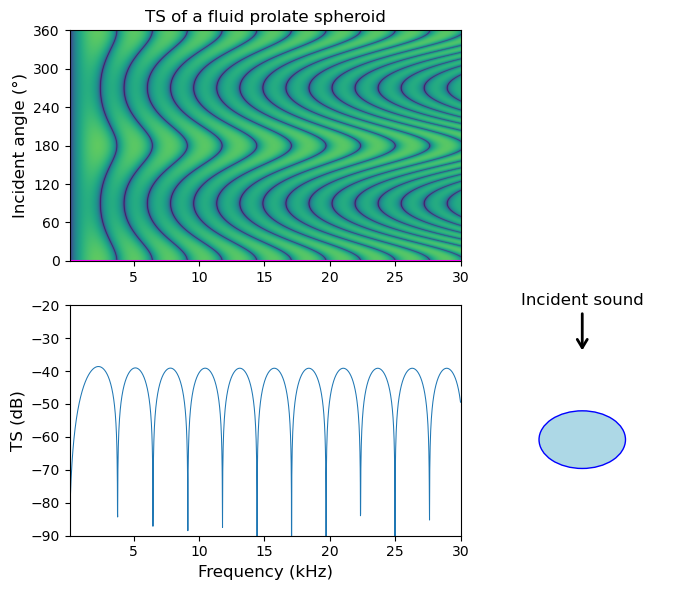

In [5]:
target1_AR = 1.5
TS_all_target1 = plot_dwba_for_prolate_spheroid(angle=0, aspect_ratio=target1_AR)

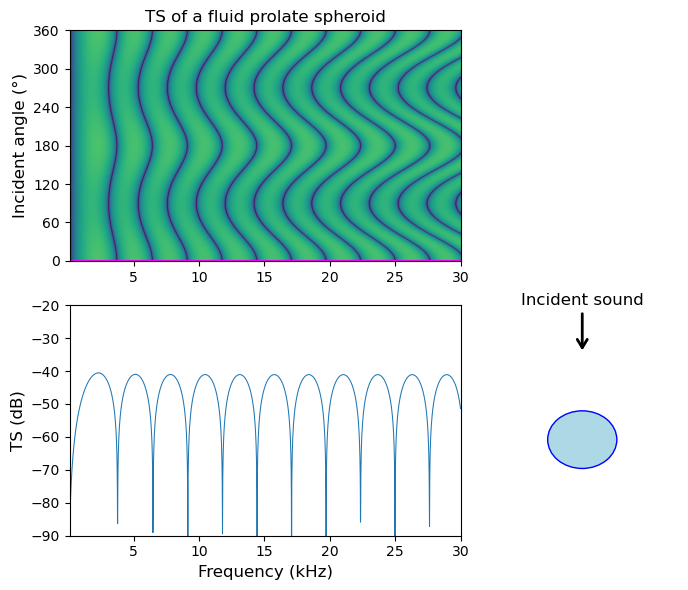

In [6]:
target2_AR = 1.2
TS_all_target2 = plot_dwba_for_prolate_spheroid(angle=0, aspect_ratio=target2_AR)

## Extract the acoustic color from the above functions and plot them side-by-side below

In [164]:
target_ARs = np.arange(1.5, 1.3, -0.1)
target_ARs

array([1.5, 1.4])

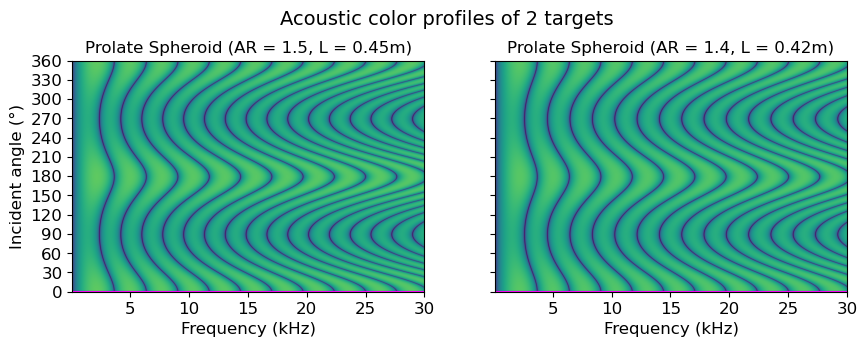

In [165]:
fig, ax = plt.subplots(1, target_ARs.shape[0], figsize=(5*target_ARs.shape[0],3), sharey=True)
plt.rcParams.update({'font.size':10})
fig.subplots_adjust(hspace=0.1)
fig.suptitle(f'Acoustic color profiles of {target_ARs.shape[0]} targets', y=1.05, fontsize=plt.rcParams['font.size']+4)

TS_all_targets = np.zeros((target_ARs.shape[0], angle_all.shape[0], freq.shape[0]))
for i, target_AR in enumerate(target_ARs):
    L = target_AR * 2*a
    phi_all = np.deg2rad(angle_all)
    fbs_full = dwba_prolate_spheroid(L, a, g, h, ka, phi_all)
    TS_all_targets[i,:,:] = 20*np.log10(np.abs(fbs_full))

    ax_TS = ax[i]
    ax_TS.set_title(f'Prolate Spheroid (AR = {target_AR:.1f}, L = {target_AR*2*a:.2f}m)')
    ax_TS.imshow(TS_all_targets[i,:] , aspect="auto", vmax=-25, vmin=-80,
                extent=(0, freq_upperbound//1e3, 0, 360))
    ax_TS.set_yticks(np.arange(0, 361, 30))
    if i==0:
        ax_TS.set_ylabel("Incident angle (°)", fontsize=12)
    ax_TS.axhline(0, color="magenta")
    ax_TS.set_xlim(freq_lowerbound/1e3, freq_upperbound/1e3)
    ax_TS.set_xlabel("Frequency (kHz)", fontsize=12)

plt.show()

In [166]:
all_waveforms_collection = np.vstack(TS_all_targets)
all_waveforms_collection

array([[-85.64708092, -83.99397243, -82.48527668, ..., -48.83383597,
        -49.13767041, -49.45380027],
       [-85.6470821 , -83.99397386, -82.48527838, ..., -48.87728219,
        -49.18283231, -49.5008053 ],
       [-85.64708564, -83.99397813, -82.48528347, ..., -49.0090163 ,
        -49.31981751, -49.64343629],
       ...,
       [-86.24635353, -84.59324675, -83.08455287, ..., -49.73818214,
        -50.05423444, -50.38350612],
       [-86.24634901, -84.59324128, -83.08454636, ..., -49.56730198,
        -49.87646179, -50.19831503],
       [-86.2463463 , -84.59323799, -83.08454245, ..., -49.46644643,
        -49.77159699, -50.08914066]], shape=(1440, 2990))

In [167]:
from sklearn.cluster import KMeans
import seaborn as sns
import pandas as pd

/Users/adityakrishna/.local/share/mamba/envs/muri-info/lib/python3.13/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


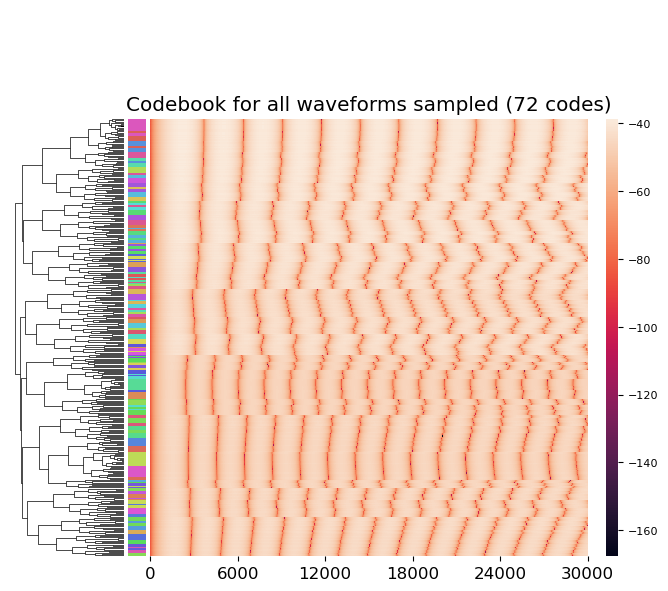

In [168]:
# Perform k-means clustering
k = all_waveforms_collection.shape[0]//20
state = 1500
kmean_TS_codebook = KMeans(n_clusters=k, n_init=10, random_state=state).fit(all_waveforms_collection)

# Create row colors for clustermap
labels = kmean_TS_codebook.labels_

# Get k distinct colors from a Seaborn palette
palette = sns.color_palette("hls", k)
# Map each cluster label to a color
row_colors = [palette[label] for label in labels]

plt.rcParams.update({'font.size':12})
# Create the clustermap
grid_cluster = sns.clustermap(
    all_waveforms_collection,
    col_cluster=False,
    row_colors=row_colors,
    cbar_pos=(1.0, 0.145, 0.02, 0.663),
    yticklabels=False,
    tree_kws=dict(linewidths=0.5, colors='k')
)

# Extract the figure and axes from sns.clustermap
fig = grid_cluster.figure
heatmap_ax = grid_cluster.ax_heatmap
dendro_ax = grid_cluster.ax_row_dendrogram

heatmap_ax.set_title(f'Codebook for all waveforms sampled ({k} codes)')
fig.set_figheight(6)
fig.set_figwidth(6)
# Adjust heatmap and dendrogram positions to align perfectly
heatmap_bbox = heatmap_ax.get_position(original=False)
dendro_bbox = dendro_ax.get_position(original=False)

# Reduce white space by directly setting the positions
heatmap_ax.set_position([heatmap_bbox.x0, heatmap_bbox.y0, heatmap_bbox.width, heatmap_bbox.height])
dendro_ax.set_position([dendro_bbox.x0, heatmap_bbox.y0, dendro_bbox.width, heatmap_bbox.height])

xticks = np.linspace(0, 3000, 6)
# Customize heatmap x-axis
heatmap_ax.set_xticks(xticks*(2985/3000))
heatmap_ax.set_xticklabels((xticks*10).astype(int), rotation=0)
heatmap_ax.set_ylabel('')
heatmap_ax.set_xlabel('')

# Adjust the colorbar position and labels
cbar = grid_cluster.cax
cbar.set_position([heatmap_bbox.x1 + 0.03, heatmap_bbox.y0, 0.02, heatmap_bbox.height]) 
cbar.tick_params(labelsize=plt.rcParams['font.size']-4)
plt.show()

In [169]:
state_angle_step = 5

In [170]:
kmean_TS_codebook.n_clusters

72

In [171]:
kmean_TS_codebook.labels_

array([62, 62, 62, ..., 62, 62, 62], shape=(1440,), dtype=int32)

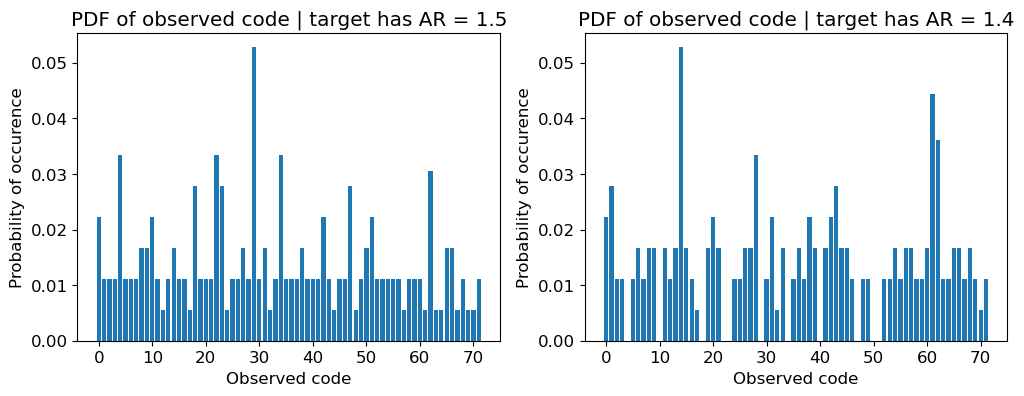

In [172]:
fig, ax = plt.subplots(1, TS_all_targets.shape[0], figsize=(6*TS_all_targets.shape[0], 4))

for i in range(TS_all_targets.shape[0]):
    target_cluster_preds = kmean_TS_codebook.predict(TS_all_targets[i,:])
    density, clusters = np.histogram(target_cluster_preds, bins=np.arange(0, kmean_TS_codebook.n_clusters+1), density=True)

    pdf_ax = ax[i]
    pdf_ax.set_title(f'PDF of observed code | target has AR = {target_ARs[i]:.1f}')
    pdf_ax.bar(x=clusters[:-1], height=density)
    pdf_ax.set_ylabel('Probability of occurence')
    pdf_ax.set_xlabel('Observed code')

plt.show()

In [173]:
state_centers = np.arange(0, 360, state_angle_step) + 2.5
state_centers

array([  2.5,   7.5,  12.5,  17.5,  22.5,  27.5,  32.5,  37.5,  42.5,
        47.5,  52.5,  57.5,  62.5,  67.5,  72.5,  77.5,  82.5,  87.5,
        92.5,  97.5, 102.5, 107.5, 112.5, 117.5, 122.5, 127.5, 132.5,
       137.5, 142.5, 147.5, 152.5, 157.5, 162.5, 167.5, 172.5, 177.5,
       182.5, 187.5, 192.5, 197.5, 202.5, 207.5, 212.5, 217.5, 222.5,
       227.5, 232.5, 237.5, 242.5, 247.5, 252.5, 257.5, 262.5, 267.5,
       272.5, 277.5, 282.5, 287.5, 292.5, 297.5, 302.5, 307.5, 312.5,
       317.5, 322.5, 327.5, 332.5, 337.5, 342.5, 347.5, 352.5, 357.5])

In [174]:
state_centers.shape

(72,)

In [175]:
state_center = state_centers[0]
state_center

np.float64(2.5)

In [176]:
angle_indices_for_state = np.where((state_center-(state_angle_step/2)<=angle_all)&(angle_all<state_center+(state_angle_step/2)))
angle_indices_for_state

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),)

In [177]:
angle_all[angle_indices_for_state]

array([0. , 0.5, 1. , 1.5, 2. , 2.5, 3. , 3.5, 4. , 4.5])

In [178]:
TS_state_target1 = TS_all_targets[0, angle_indices_for_state, :][0]
TS_state_target1

array([[-85.64708092, -83.99397243, -82.48527668, ..., -48.83383597,
        -49.13767041, -49.45380027],
       [-85.6470821 , -83.99397386, -82.48527838, ..., -48.87728219,
        -49.18283231, -49.5008053 ],
       [-85.64708564, -83.99397813, -82.48528347, ..., -49.0090163 ,
        -49.31981751, -49.64343629],
       ...,
       [-85.64713858, -83.9940422 , -82.48535972, ..., -51.28524161,
        -51.69982702, -52.13650189],
       [-85.6471562 , -83.99406352, -82.48538509, ..., -52.20411446,
        -52.66873996, -53.16094575],
       [-85.64717615, -83.99408766, -82.48541383, ..., -53.38044615,
        -53.91743554, -54.49115328]], shape=(10, 2990))

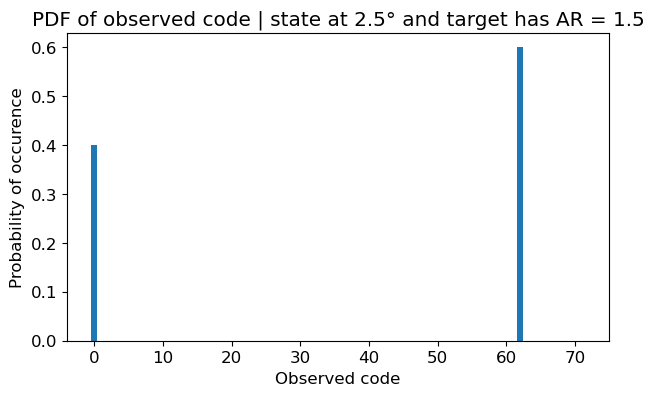

In [179]:
target1_state_cluster_preds = kmean_TS_codebook.predict(TS_state_target1)
density, clusters = np.histogram(target1_state_cluster_preds, bins=np.arange(0, kmean_TS_codebook.n_clusters+1), density=True)

fig, ax = plt.subplots(1, 1, figsize=(7,4))

ax.set_title(f'PDF of observed code | state at {state_center}° and target has AR = {target1_AR}')
ax.bar(x=clusters[:-1], height=density)
ax.set_ylabel('Probability of occurence')
ax.set_xlabel('Observed code')
plt.show()

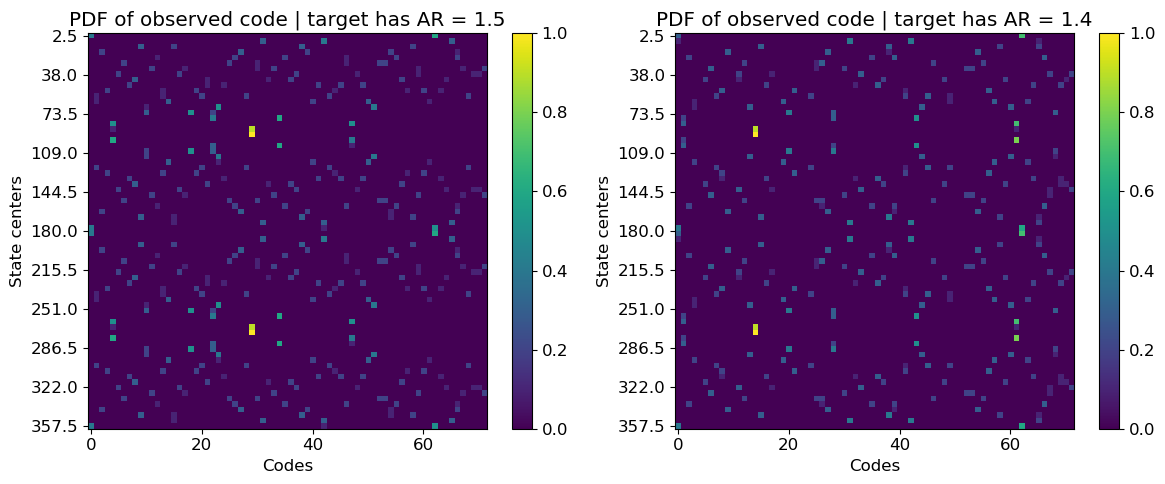

In [180]:
fig, ax_all = plt.subplots(1, TS_all_targets.shape[0], figsize=(6*TS_all_targets.shape[0], 5))

emission_matrix_B_targets = np.zeros((state_centers.shape[0], kmean_TS_codebook.n_clusters, TS_all_targets.shape[0]))
for k in range(TS_all_targets.shape[0]):
    for i, state_center in enumerate(state_centers):
        angle_indices_for_state = np.where((state_center-(state_angle_step/2)<=angle_all)&(angle_all<state_center+(state_angle_step/2)))
        TS_state_target_k = TS_all_targets[k, angle_indices_for_state][0]
        target_k_state_cluster_preds = kmean_TS_codebook.predict(TS_state_target_k)

        density, clusters = np.histogram(target_k_state_cluster_preds, bins=np.arange(0, kmean_TS_codebook.n_clusters+1), density=True)
        emission_matrix_B_targets[i, :, k] = density

    ax = ax_all[k]
    im = ax.imshow(emission_matrix_B_targets[:,:,k], aspect='auto')
    fig.colorbar(im, ax=ax)
    ax.set_title(f'PDF of observed code | target has AR = {target_ARs[k]}')

    ax.set_yticks(np.linspace(0, state_centers.shape[0]-1, 11))
    ax.set_yticklabels(np.linspace(0, 355, 11)+2.5)
    ax.set_ylabel('State centers')
    ax.set_xlabel('Codes')

plt.tight_layout()
plt.show()

In [181]:
state_centers

array([  2.5,   7.5,  12.5,  17.5,  22.5,  27.5,  32.5,  37.5,  42.5,
        47.5,  52.5,  57.5,  62.5,  67.5,  72.5,  77.5,  82.5,  87.5,
        92.5,  97.5, 102.5, 107.5, 112.5, 117.5, 122.5, 127.5, 132.5,
       137.5, 142.5, 147.5, 152.5, 157.5, 162.5, 167.5, 172.5, 177.5,
       182.5, 187.5, 192.5, 197.5, 202.5, 207.5, 212.5, 217.5, 222.5,
       227.5, 232.5, 237.5, 242.5, 247.5, 252.5, 257.5, 262.5, 267.5,
       272.5, 277.5, 282.5, 287.5, 292.5, 297.5, 302.5, 307.5, 312.5,
       317.5, 322.5, 327.5, 332.5, 337.5, 342.5, 347.5, 352.5, 357.5])

In [221]:
def w_(theta):
    sigma_i = state_angle_step / 2
    normalization = 1 / np.sqrt(2*np.pi*(sigma_i**2))

    return normalization * np.exp(-0.5*((theta/sigma_i)**2))

def state_transition_model(delta_angle):
    distances = np.abs(state_centers[:, np.newaxis] - state_centers[np.newaxis, :])

    return w_(distances - delta_angle)

In [222]:
prior_class_prob = 1/2
true_target_L = target_ARs[1]*2*a
posteriors = np.zeros((3600, target_ARs.shape[0]))

initial_state_prob = state_angle_step / 360
for i_state, initial_state in enumerate(np.arange(0, 360, 0.1)):
    # initial_state = 1 # np.random.uniform(low=0, high=360)

    alpha_targets = initial_state_prob * emission_matrix_B_targets

    phi = np.deg2rad(initial_state)
    fbs = dwba_prolate_spheroid(true_target_L, a, g, h, ka, phi)

    received_TS = 20*np.log10(np.abs(fbs))
    received_code = kmean_TS_codebook.predict(received_TS.reshape((1, freq.shape[0])))[0]
    alpha_targets_for_received_code = alpha_targets[:,received_code,:]
    likelihood_targets_for_received_code = alpha_targets_for_received_code.sum(axis=0)
    posterior = (likelihood_targets_for_received_code) / np.sum(likelihood_targets_for_received_code)
    posteriors[i_state,:] = posterior

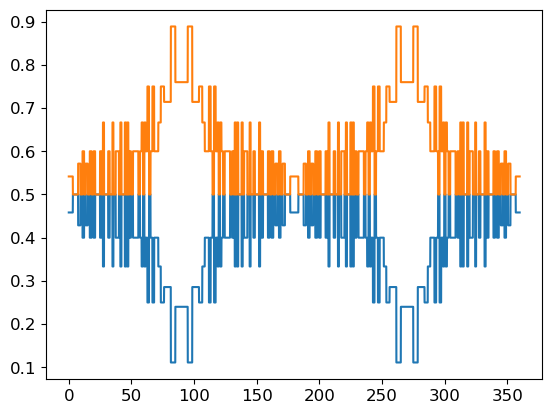

In [223]:
plt.plot(np.arange(0, 360, 0.1), posteriors)

In [224]:
prior_class_prob = 1/2
true_target_L = target_ARs[1]*2*a
posteriors = np.zeros((3600, target_ARs.shape[0]))

initial_state_prob = state_angle_step / 360
initial_state = 153 # np.random.uniform(low=0, high=360)

alpha_targets = initial_state_prob * emission_matrix_B_targets

phi = np.deg2rad(initial_state)
fbs = dwba_prolate_spheroid(true_target_L, a, g, h, ka, phi)

received_TS = 20*np.log10(np.abs(fbs))
received_code = kmean_TS_codebook.predict(received_TS.reshape((1, freq.shape[0])))[0]
alpha_targets_for_received_code = alpha_targets[:,received_code,:]
likelihood_targets_for_received_code = alpha_targets_for_received_code.sum(axis=0)
posterior = (likelihood_targets_for_received_code) / np.sum(likelihood_targets_for_received_code)
posterior

array([0.5, 0.5])

In [225]:
emission_matrix_B_targets[:,received_code,:]

array([[0. , 0. ],
       [0. , 0. ],
       [0. , 0. ],
       [0. , 0. ],
       [0.2, 0. ],
       [0. , 0.2],
       [0. , 0. ],
       [0. , 0. ],
       [0. , 0. ],
       [0. , 0. ],
       [0. , 0. ],
       [0. , 0. ],
       [0. , 0. ],
       [0. , 0. ],
       [0. , 0. ],
       [0. , 0. ],
       [0. , 0. ],
       [0. , 0. ],
       [0. , 0. ],
       [0. , 0. ],
       [0. , 0. ],
       [0. , 0. ],
       [0. , 0. ],
       [0. , 0. ],
       [0. , 0. ],
       [0. , 0. ],
       [0. , 0. ],
       [0. , 0. ],
       [0. , 0. ],
       [0. , 0. ],
       [0. , 0.2],
       [0.2, 0. ],
       [0. , 0. ],
       [0. , 0. ],
       [0. , 0. ],
       [0. , 0. ],
       [0. , 0. ],
       [0. , 0. ],
       [0. , 0. ],
       [0. , 0. ],
       [0.2, 0. ],
       [0. , 0.2],
       [0. , 0. ],
       [0. , 0. ],
       [0. , 0. ],
       [0. , 0. ],
       [0. , 0. ],
       [0. , 0. ],
       [0. , 0. ],
       [0. , 0. ],
       [0. , 0. ],
       [0. , 0. ],
       [0. ,

In [226]:
alpha_targets_for_received_code.shape

(72, 2)

In [227]:
entropy_of_current_belief = -1 * np.sum(posterior * np.log10(posterior + np.nextafter(0, 1)))
entropy_of_current_belief

np.float64(0.3010299956639812)

In [228]:
candidate_angle_steps = np.arange(-1, 2, 2)
candidate_angle_steps

array([-1,  1])

In [229]:
candidate_next_states = candidate_angle_steps + initial_state
candidate_next_states

array([152, 154])

In [230]:
candidate_angle_step = candidate_angle_steps[0]
candidate_next_state = candidate_next_states[0]
candidate_next_state, candidate_angle_step

(np.int64(152), np.int64(-1))

In [231]:
A_step = state_transition_model(candidate_angle_step)
A_step

array([[1.47308056e-01, 8.95781212e-03, 9.97698852e-06, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [8.95781212e-03, 1.47308056e-01, 8.95781212e-03, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [9.97698852e-06, 8.95781212e-03, 1.47308056e-01, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       ...,
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        1.47308056e-01, 8.95781212e-03, 9.97698852e-06],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        8.95781212e-03, 1.47308056e-01, 8.95781212e-03],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        9.97698852e-06, 8.95781212e-03, 1.47308056e-01]], shape=(72, 72))

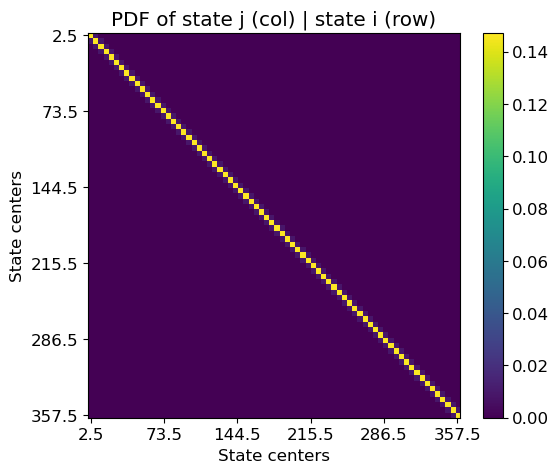

In [232]:
fig, ax = plt.subplots(1, 1, figsize=(6, 5))

im = ax.imshow(A_step, aspect='auto')
fig.colorbar(im, ax=ax)
ax.set_title(f'PDF of state j (col) | state i (row)')

ax.set_yticks(np.linspace(0, state_centers.shape[0]-1, 6))
ax.set_yticklabels(np.linspace(0, 355, 6)+2.5)

ax.set_xticks(np.linspace(0, state_centers.shape[0]-1, 6))
ax.set_xticklabels(np.linspace(0, 355, 6)+2.5)
ax.set_ylabel('State centers')
ax.set_xlabel('State centers')
plt.show()

In [233]:
test_a = np.array([[1, 2, 3],
                   [4, 5, 6]]).T
test_M = np.array([[3, 4, 5],
                   [5, 6, 1],
                   [8, 5, 2]])
test_a, test_M

(array([[1, 4],
        [2, 5],
        [3, 6]]),
 array([[3, 4, 5],
        [5, 6, 1],
        [8, 5, 2]]))

In [234]:
np.matmul(test_a.T, test_M) == np.array([[np.sum(test_a[:,0] * test_M[:,0]), np.sum(test_a[:,0] * test_M[:,1]), np.sum(test_a[:,0] * test_M[:,2])],
                                       [np.sum(test_a[:,1] * test_M[:,0]), np.sum(test_a[:,1] * test_M[:,1]), np.sum(test_a[:,1] * test_M[:,2])]])

array([[ True,  True,  True],
       [ True,  True,  True]])

In [235]:
likelihood_observing_and_transitioning = np.matmul(alpha_targets_for_received_code.T, A_step).T
likelihood_observing_and_transitioning

array([[2.11231282e-019, 1.44551291e-027],
       [5.65348920e-013, 2.11231282e-019],
       [2.77138570e-008, 5.65348920e-013],
       [2.48828114e-005, 2.77138570e-008],
       [4.09189045e-004, 2.48828114e-005],
       [2.48828114e-005, 4.09189045e-004],
       [2.77138570e-008, 2.48828114e-005],
       [5.65348920e-013, 2.77138570e-008],
       [2.11231282e-019, 5.65348920e-013],
       [1.44551291e-027, 2.11231282e-019],
       [1.81178971e-037, 1.44551291e-027],
       [4.15925620e-049, 1.81178971e-037],
       [1.74882209e-062, 4.15925620e-049],
       [1.34678311e-077, 1.74882209e-062],
       [1.89964200e-094, 1.34678311e-077],
       [4.90758620e-113, 1.89964200e-094],
       [2.32212815e-133, 4.90758620e-113],
       [2.01245650e-155, 2.32212815e-133],
       [2.01245650e-155, 2.32212815e-133],
       [2.32212815e-133, 4.90758620e-113],
       [4.90758620e-113, 1.89964200e-094],
       [1.89964200e-094, 1.34678311e-077],
       [1.34678311e-077, 1.74882209e-062],
       [1.7

In [236]:
alpha_targets_for_forecasted_codes = likelihood_observing_and_transitioning[:, np.newaxis, :] * emission_matrix_B_targets
alpha_targets_for_forecasted_codes

array([[[8.44925128e-20, 4.33653873e-28],
        [0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00],
        ...,
        [0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00]],

       [[0.00000000e+00, 2.11231282e-20],
        [0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00],
        ...,
        [0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00]],

       [[0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00],
        ...,
        [0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00]],

       ...,

       [[0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00],
        ...,
        [0.00000000e+00, 0.00000000e+00],
     

In [237]:
likelihood_targets_for_forecasted_codes = alpha_targets_for_forecasted_codes.sum(axis=0)
(likelihood_targets_for_forecasted_codes, likelihood_targets_for_forecasted_codes.shape)

(array([[3.37970052e-019, 4.22462584e-020],
        [2.49555372e-049, 1.89964200e-094],
        [1.99062492e-005, 1.99062492e-005],
        [1.44943176e-037, 2.49555372e-049],
        [5.10868193e-133, 0.00000000e+000],
        [4.52279136e-013, 4.52279136e-013],
        [1.99062492e-005, 2.98593737e-005],
        [1.15641033e-027, 1.44943176e-037],
        [2.53477538e-019, 4.22462578e-020],
        [3.32566284e-008, 3.32566284e-008],
        [8.08069863e-078, 0.00000000e+000],
        [2.21710856e-008, 2.77139701e-008],
        [1.63675618e-004, 3.27351236e-004],
        [1.08707382e-037, 2.09858651e-062],
        [2.09858651e-062, 8.82408697e-133],
        [1.66284273e-008, 6.78418704e-013],
        [4.52279136e-013, 1.68985026e-019],
        [1.10855428e-008, 1.10855428e-008],
        [3.79928399e-094, 0.00000000e+000],
        [1.44943176e-037, 4.99110744e-049],
        [3.32740496e-049, 2.15485297e-077],
        [1.26738769e-019, 1.73461549e-027],
        [1.89964200e-094, 0.0000

In [238]:
numerator = likelihood_targets_for_forecasted_codes.sum(axis=1)
denominator = likelihood_targets_for_received_code.sum()
numerator / denominator

array([1.71097340e-017, 1.12299917e-047, 1.79156242e-003, 6.52244294e-036,
       2.29890687e-131, 4.07051223e-011, 2.23945303e-003, 5.20384648e-026,
       1.33075708e-017, 2.99309655e-006, 3.63631438e-076, 2.24482750e-006,
       2.20962084e-002, 4.89183220e-036, 9.44363928e-061, 7.48309756e-007,
       2.03525687e-011, 9.97698852e-007, 1.70967780e-092, 6.52244294e-036,
       1.49733223e-047, 5.70324470e-018, 8.54838898e-093, 1.57393988e-061,
       2.60192324e-026, 1.21678307e-002, 3.33682579e-002, 1.34516837e-003,
       1.49733223e-047, 3.44130062e-153, 1.56786655e-003, 3.05288569e-011,
       7.60432615e-018, 2.49424713e-006, 5.30019310e-111, 1.56265868e-002,
       1.90108154e-017, 4.07051223e-011, 1.74600861e-006, 2.01575715e-003,
       6.29575952e-061, 9.10673134e-026, 3.56169991e-011, 1.49733223e-047,
       3.26122147e-036, 5.20384648e-026, 2.60028551e-002, 4.41682758e-112,
       3.05288417e-011, 5.20384648e-026, 9.44363928e-061, 9.69683836e-076,
       1.79156242e-003, 1

In [239]:
forecasted_posteriors_for_codes = (likelihood_targets_for_forecasted_codes / np.sum(likelihood_targets_for_forecasted_codes))
(forecasted_posteriors_for_codes, forecasted_posteriors_for_codes.shape)

(array([[9.20377501e-017, 1.15047193e-017],
        [6.79602077e-047, 5.17320319e-092],
        [5.42097257e-003, 5.42097257e-003],
        [3.94716744e-035, 6.79602077e-047],
        [1.39122265e-130, 0.00000000e+000],
        [1.23166990e-010, 1.23166990e-010],
        [5.42097257e-003, 8.13145886e-003],
        [3.14919633e-025, 3.94716744e-035],
        [6.90283123e-017, 1.15047191e-017],
        [9.05661679e-006, 9.05661679e-006],
        [2.20057758e-075, 0.00000000e+000],
        [6.03774453e-006, 7.54721145e-006],
        [4.45729896e-002, 8.91459791e-002],
        [2.96037558e-035, 5.71497915e-060],
        [5.71497915e-060, 2.40302094e-130],
        [4.52833919e-006, 1.84750485e-010],
        [1.23166990e-010, 4.60188749e-017],
        [3.01887226e-006, 3.01887226e-006],
        [1.03464064e-091, 0.00000000e+000],
        [3.94716744e-035, 1.35920415e-046],
        [9.06136103e-047, 5.86820689e-075],
        [3.45141562e-017, 4.72379449e-025],
        [5.17320319e-092, 0.0000

In [240]:
entropy_of_forecasted_belief_for_codes = -1 * (forecasted_posteriors_for_codes * np.log(forecasted_posteriors_for_codes + np.nextafter(0, 1))).sum(axis=1)
entropy_of_forecasted_belief_for_codes

array([3.84715999e-015, 7.22452090e-045, 5.65676324e-002, 3.12684658e-033,
       4.15983751e-128, 5.62072068e-009, 6.74125176e-002, 1.77669721e-023,
       3.01741006e-015, 2.10331139e-004, 3.78290646e-073, 1.61572795e-004,
       3.54158580e-001, 2.35365140e-033, 7.79591822e-058, 5.57260576e-005,
       2.81036207e-009, 7.67435199e-005, 2.16758444e-089, 3.12684658e-033,
       9.60662662e-045, 1.30826471e-015, 1.08737801e-089, 1.31638615e-058,
       8.99262888e-024, 2.11446826e-001, 4.61639377e-001, 3.92338670e-002,
       9.60662662e-045, 7.27354110e-150, 5.06731158e-002, 4.14063403e-009,
       1.76301196e-015, 1.77724044e-004, 8.08671804e-108, 2.43792441e-001,
       4.29979670e-015, 5.62072068e-009, 1.25400384e-004, 6.21325466e-002,
       5.21272698e-058, 3.11601487e-023, 4.79751340e-009, 9.60662662e-045,
       1.57710313e-033, 1.77669721e-023, 3.98671634e-001, 6.80535123e-109,
       4.25822693e-009, 1.77669721e-023, 7.79591822e-058, 1.00301935e-072,
       5.65676324e-002, 5

In [241]:
expected_entropy_of_forecasted_belief = (entropy_of_forecasted_belief_for_codes * numerator / denominator).sum()
expected_entropy_of_forecasted_belief

np.float64(0.056369778572946685)

In [242]:
delta_S = entropy_of_current_belief - expected_entropy_of_forecasted_belief
delta_S

np.float64(0.24466021709103453)

In [243]:
candidate_angle_step = candidate_angle_steps[1]
candidate_next_state = candidate_next_states[1]
candidate_next_state, candidate_angle_step

(np.int64(154), np.int64(1))

In [244]:
A_step = state_transition_model(candidate_angle_step)
A_step

array([[0.14730806, 0.04436833, 0.00024476, ..., 0.        , 0.        ,
        0.        ],
       [0.04436833, 0.14730806, 0.04436833, ..., 0.        , 0.        ,
        0.        ],
       [0.00024476, 0.04436833, 0.14730806, ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.14730806, 0.04436833,
        0.00024476],
       [0.        , 0.        , 0.        , ..., 0.04436833, 0.14730806,
        0.04436833],
       [0.        , 0.        , 0.        , ..., 0.00024476, 0.04436833,
        0.14730806]], shape=(72, 72))

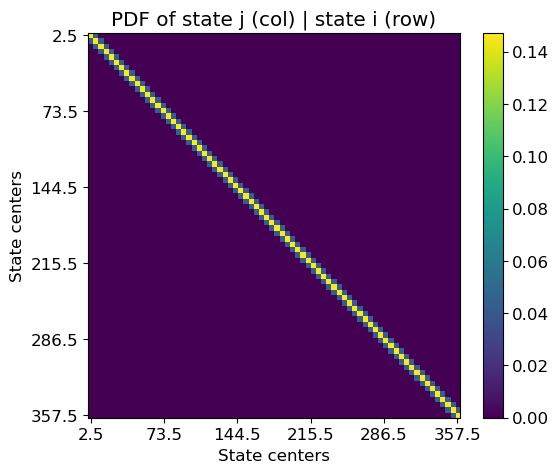

In [245]:
fig, ax = plt.subplots(1, 1, figsize=(6, 5))

im = ax.imshow(A_step, aspect='auto')
fig.colorbar(im, ax=ax)
ax.set_title(f'PDF of state j (col) | state i (row)')

ax.set_yticks(np.linspace(0, state_centers.shape[0]-1, 6))
ax.set_yticklabels(np.linspace(0, 355, 6)+2.5)

ax.set_xticks(np.linspace(0, state_centers.shape[0]-1, 6))
ax.set_xticklabels(np.linspace(0, 355, 6)+2.5)
ax.set_ylabel('State centers')
ax.set_xlabel('State centers')
plt.show()

In [246]:
likelihood_observing_and_transitioning = np.matmul(alpha_targets_for_received_code.T, A_step).T
likelihood_observing_and_transitioning

array([[1.27128499e-016, 4.30901326e-024],
       [6.86957833e-011, 1.27128499e-016],
       [6.79891033e-007, 6.86957833e-011],
       [1.23245372e-004, 6.79891033e-007],
       [4.09189045e-004, 1.23245372e-004],
       [1.23245372e-004, 4.09189045e-004],
       [6.79891033e-007, 1.23245372e-004],
       [6.86957833e-011, 6.79891033e-007],
       [1.27128499e-016, 6.86957833e-011],
       [4.30901326e-024, 1.27128499e-016],
       [2.67506792e-033, 4.30901326e-024],
       [3.04168244e-044, 2.67506792e-033],
       [6.33453877e-057, 3.04168244e-044],
       [2.41622959e-071, 6.33453877e-057],
       [1.68804287e-087, 2.41622959e-071],
       [2.15998541e-105, 1.68804287e-087],
       [5.06221092e-125, 2.15998541e-105],
       [2.17295997e-146, 5.06221092e-125],
       [2.17295997e-146, 5.06221092e-125],
       [5.06221092e-125, 2.15998541e-105],
       [2.15998541e-105, 1.68804287e-087],
       [1.68804287e-087, 2.41622959e-071],
       [2.41622959e-071, 6.33453877e-057],
       [6.3

In [247]:
alpha_targets_for_forecasted_codes = likelihood_observing_and_transitioning[:, np.newaxis, :] * emission_matrix_B_targets
alpha_targets_for_forecasted_codes

array([[[5.08513996e-17, 1.29270398e-24],
        [0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00],
        ...,
        [0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00]],

       [[0.00000000e+00, 1.27128499e-17],
        [0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00],
        ...,
        [0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00]],

       [[0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00],
        ...,
        [0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00]],

       ...,

       [[0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00],
        ...,
        [0.00000000e+00, 0.00000000e+00],
     

In [248]:
likelihood_targets_for_forecasted_codes = alpha_targets_for_forecasted_codes.sum(axis=0)
(likelihood_targets_for_forecasted_codes, likelihood_targets_for_forecasted_codes.shape)

(array([[2.03405602e-016, 2.54257058e-017],
        [1.82500946e-044, 1.68804287e-087],
        [9.85962975e-005, 9.85962975e-005],
        [2.14005434e-033, 1.82500946e-044],
        [1.11368640e-124, 0.00000000e+000],
        [5.49566267e-011, 5.49566267e-011],
        [9.85962975e-005, 1.47894446e-004],
        [3.44721061e-024, 2.14005434e-033],
        [1.52554199e-016, 2.54257041e-017],
        [8.15869240e-007, 8.15869240e-007],
        [1.44973776e-071, 0.00000000e+000],
        [5.43912827e-007, 6.79904773e-007],
        [1.63675618e-004, 3.27351236e-004],
        [1.60504075e-033, 7.60144652e-057],
        [7.60144652e-057, 1.92364015e-124],
        [4.07948359e-007, 8.24349400e-011],
        [5.49566267e-011, 1.01702799e-016],
        [2.71956413e-007, 2.71956413e-007],
        [3.37608574e-087, 0.00000000e+000],
        [2.14005434e-033, 3.65001892e-044],
        [2.43334595e-044, 3.86596735e-071],
        [7.62771002e-017, 5.17081591e-024],
        [1.68804287e-087, 0.0000

In [249]:
numerator = likelihood_targets_for_forecasted_codes.sum(axis=1)
denominator = likelihood_targets_for_received_code.sum()
numerator / denominator

array([1.02974088e-014, 8.21254258e-043, 8.87366677e-003, 9.63024453e-032,
       5.01158881e-123, 4.94609640e-009, 1.10920835e-002, 1.55124477e-022,
       8.00909563e-015, 7.34282316e-005, 6.52381990e-070, 5.50717920e-005,
       2.20962084e-002, 7.22268340e-032, 3.42065093e-055, 1.83613857e-005,
       2.47305278e-009, 2.44760772e-005, 1.51923858e-085, 9.63024453e-032,
       1.09500568e-042, 3.43246974e-015, 7.59619292e-086, 5.70108489e-056,
       7.75622387e-023, 1.65941459e-002, 3.42535210e-002, 6.69196420e-003,
       1.09500568e-042, 3.71576155e-144, 7.77057745e-003, 3.70958145e-009,
       4.57662596e-015, 6.11901930e-005, 2.33278424e-103, 1.91676390e-002,
       1.14415649e-014, 4.94609640e-009, 4.28374629e-005, 9.98899414e-003,
       2.28043396e-055, 2.71467835e-022, 4.32784465e-009, 1.09500568e-042,
       4.81512226e-032, 1.55124477e-022, 2.68881182e-002, 1.94398687e-104,
       3.70957230e-009, 1.55124477e-022, 3.42065093e-055, 1.73968531e-069,
       8.87366677e-003, 8

In [250]:
forecasted_posteriors_for_codes = (likelihood_targets_for_forecasted_codes / np.sum(likelihood_targets_for_forecasted_codes))
(forecasted_posteriors_for_codes, forecasted_posteriors_for_codes.shape)

(array([[3.86973571e-014, 4.83717070e-015],
        [3.47203038e-042, 3.21145520e-085],
        [1.87576748e-002, 1.87576748e-002],
        [4.07139461e-031, 3.47203038e-042],
        [2.11875779e-122, 0.00000000e+000],
        [1.04553473e-008, 1.04553473e-008],
        [1.87576748e-002, 2.81365122e-002],
        [6.55822351e-022, 4.07139461e-031],
        [2.90230173e-014, 4.83717038e-015],
        [1.55216882e-004, 1.55216882e-004],
        [2.75808627e-069, 0.00000000e+000],
        [1.03477922e-004, 1.29350016e-004],
        [3.11388368e-002, 6.22776736e-002],
        [3.05354596e-031, 1.44615432e-054],
        [1.44615432e-054, 3.65967255e-122],
        [7.76110550e-005, 1.56830209e-008],
        [1.04553473e-008, 1.93486782e-014],
        [5.17389608e-005, 5.17389608e-005],
        [6.42291041e-085, 0.00000000e+000],
        [4.07139461e-031, 6.94406076e-042],
        [4.62937384e-042, 7.35489671e-069],
        [1.45115088e-014, 9.83733526e-022],
        [3.21145520e-085, 0.0000

In [251]:
entropy_of_forecasted_belief_for_codes = -1 * (forecasted_posteriors_for_codes * np.log(forecasted_posteriors_for_codes + np.nextafter(0, 1))).sum(axis=1)
entropy_of_forecasted_belief_for_codes

array([1.35453566e-012, 3.31453333e-040, 1.49166743e-001, 2.84900529e-029,
       5.93600827e-120, 3.84258108e-007, 1.75050055e-001, 3.19884909e-020,
       1.06411236e-012, 2.72271744e-003, 4.35402074e-067, 2.10759837e-003,
       2.80922256e-001, 2.14553847e-029, 1.79280745e-052, 7.34777390e-004,
       1.92129665e-007, 1.02125460e-003, 1.24514452e-082, 2.84900529e-029,
       4.40605990e-040, 4.62392361e-013, 6.24798273e-083, 3.03119843e-053,
       1.62215362e-020, 2.27140013e-001, 3.78780831e-001, 1.01828042e-001,
       4.40605990e-040, 5.16546369e-141, 1.34652495e-001, 2.81835858e-007,
       6.24368292e-013, 2.31088789e-003, 2.31644475e-100, 2.47475678e-001,
       1.51562420e-012, 3.84258108e-007, 1.63477868e-003, 1.62651723e-001,
       1.19911407e-052, 5.61213602e-020, 3.25987911e-007, 4.40605990e-040,
       1.43861302e-029, 3.19884909e-020, 3.25448947e-001, 1.95079314e-101,
       2.91817128e-007, 3.19884909e-020, 1.79280745e-052, 1.15385830e-066,
       1.49166743e-001, 1

In [252]:
expected_entropy_of_forecasted_belief = (entropy_of_forecasted_belief_for_codes * numerator / denominator).sum()
expected_entropy_of_forecasted_belief

np.float64(0.061827739437769355)

In [253]:
delta_S = entropy_of_current_belief - expected_entropy_of_forecasted_belief
delta_S

np.float64(0.23920225622621183)

In [255]:
prior_class_prob = 1/2
true_target_L = target_ARs[1]*2*a
posteriors = np.zeros((3600, target_ARs.shape[0]))
candidate_angle_steps = np.arange(-1, 2, 2)

initial_state_prob = state_angle_step / 360
optim_angle_steps = np.zeros(3600)

for i_state, initial_state in enumerate(np.arange(0, 360, 0.1)):
    # initial_state = 153 # np.random.uniform(low=0, high=360)

    alpha_targets = initial_state_prob * emission_matrix_B_targets

    phi = np.deg2rad(initial_state)
    fbs = dwba_prolate_spheroid(true_target_L, a, g, h, ka, phi)

    received_TS = 20*np.log10(np.abs(fbs))
    received_code = kmean_TS_codebook.predict(received_TS.reshape((1, freq.shape[0])))[0]
    alpha_targets_for_received_code = alpha_targets[:,received_code,:]
    likelihood_targets_for_received_code = alpha_targets_for_received_code.sum(axis=0)
    posterior = (likelihood_targets_for_received_code) / np.sum(likelihood_targets_for_received_code)
    posteriors[i_state,:] = posterior

    entropy_of_current_belief = -1 * np.sum(posterior * np.log10(posterior + np.nextafter(0, 1)))
    candidate_next_states = candidate_angle_steps + initial_state
    forecasted_delta_S_vals_per_trial = np.zeros(candidate_angle_steps.shape[0])

    for a_step, candidate_angle_step in enumerate(candidate_angle_steps):
        A_step = state_transition_model(candidate_angle_step)
        likelihood_observing_and_transitioning = np.matmul(alpha_targets_for_received_code.T, A_step).T

        alpha_targets_for_forecasted_codes = likelihood_observing_and_transitioning[:, np.newaxis, :] * emission_matrix_B_targets
        likelihood_targets_for_forecasted_codes = alpha_targets_for_forecasted_codes.sum(axis=0)

        numerator = likelihood_targets_for_forecasted_codes.sum(axis=1)
        denominator = likelihood_targets_for_received_code.sum()

        forecasted_posteriors_for_codes = (likelihood_targets_for_forecasted_codes / np.sum(likelihood_targets_for_forecasted_codes))
        entropy_of_forecasted_belief_for_codes = -1 * (forecasted_posteriors_for_codes * np.log(forecasted_posteriors_for_codes + np.nextafter(0, 1))).sum(axis=1)
        expected_entropy_of_forecasted_belief = (entropy_of_forecasted_belief_for_codes * numerator / denominator).sum()

        delta_S = entropy_of_current_belief - expected_entropy_of_forecasted_belief
        forecasted_delta_S_vals_per_trial[a_step] = delta_S

    angle_step_to_make = candidate_angle_steps[(forecasted_delta_S_vals_per_trial).argmax()]
    optim_angle_steps[i_state] = angle_step_to_make

optim_angle_steps

array([-1., -1., -1., ..., -1., -1., -1.], shape=(3600,))

In [256]:
optim_angle_steps.sum()

np.float64(-3600.0)